# Installs & Imports

In [1]:
!pip install -q stable-baselines3[extra] gymnasium tqdm optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 32.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.8 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.monitor import Monitor
from gym.wrappers import StepAPICompatibility
import matplotlib.pyplot as plt
import optuna
import json
from tqdm import tqdm
import imageio
from IPython.display import Image, display

# Load the Data

In [3]:
# Load the CartPole environment using Gymnasium
env_id = 'CartPole-v1'
env = gym.make(env_id, render_mode='rgb_array')

# Apply necessary wrappers
env = Monitor(env)
env = DummyVecEnv([lambda: env])

# Print the action and observation spaces
print(f'Action space: {env.action_space}')
print(f'Observation space: {env.observation_space}')

Action space: Discrete(2)
Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Define Custom Callback

In [4]:
# CustomCallback class for plotting metrics during training
class CustomCallback(BaseCallback):
    """
    Custom callback for plotting additional metrics during training.
    """
    def __init__(self, verbose=0):
        super(CustomCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.current_rewards = 0  # To accumulate rewards during an episode

    def _on_step(self) -> bool:
        # Accumulate rewards during an episode
        self.current_rewards += self.locals['rewards'][0]  # Single environment

        # Check if the episode is done
        done = self.locals['dones'][0]
        if done:
            # Store the accumulated reward for the episode
            self.episode_rewards.append(self.current_rewards)
            # Reset the accumulated rewards
            self.current_rewards = 0

        return True

    def _on_training_end(self) -> None:
        # Plot the rewards at the end of training
        plt.figure(figsize=(12, 8))
        plt.plot(self.episode_rewards)
        plt.xlabel('Episodes')
        plt.ylabel('Total Reward')
        plt.title('Training Rewards Over Time')
        plt.show()

# Define the Model

In [5]:
# Initialize the PPO model
model = PPO('MlpPolicy', env, verbose=1)

Using cuda device


In [6]:
# Function to create a GIF from frames
def save_gif(frames, path="./cartpole.gif", duration=33):
    imageio.mimsave(path, frames, duration=duration)  # duration is in milliseconds

# Function to run the environment and capture frames
def run_and_capture_gif(model, env, episodes=1, path="./cartpole.gif", duration=33):
    frames = []
    for episode in range(episodes):
        obs = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, info = env.step(action)

            # Capture the rendered frame
            frame = env.render()
            if frame is not None:
                frames.append(frame)

    save_gif(frames, path, duration=duration)
    env.close()
    print(f"GIF saved at {path}")

    # Display the GIF in the notebook
    display(Image(open(path, 'rb').read()))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Capturing performance before training...
GIF saved at ./before_training.gif


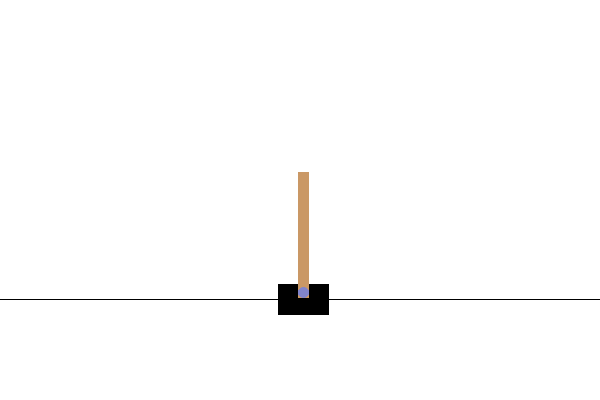

In [7]:
# Capture model performance before training
print("Capturing performance before training...")
run_and_capture_gif(model, env, episodes=50, path="./before_training.gif", duration=500)

# Define Training Details

In [8]:
# Define a stopping callback to stop training when a reward threshold is met
reward_threshold = 475
stop_training_callback = StopTrainingOnRewardThreshold(reward_threshold=reward_threshold, verbose=1)

# Create an evaluation callback that uses the stop training callback
eval_callback = EvalCallback(env, best_model_save_path='./logs/',
                             log_path='./logs/', eval_freq=500,
                             deterministic=True, render=False,
                             callback_on_new_best=stop_training_callback)

# Combine the custom callback with the eval callback
callbacks = [CustomCallback(), eval_callback]

# Train the Model

Eval num_timesteps=500, episode_reward=121.60 +/- 46.02
Episode length: 121.60 +/- 46.02
---------------------------------
| eval/              |          |
|    mean_ep_length  | 122      |
|    mean_reward     | 122      |
| time/              |          |
|    total_timesteps | 500      |
---------------------------------
New best mean reward!
Eval num_timesteps=1000, episode_reward=161.80 +/- 57.05
Episode length: 161.80 +/- 57.05
---------------------------------
| eval/              |          |
|    mean_ep_length  | 162      |
|    mean_reward     | 162      |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
New best mean reward!
Eval num_timesteps=1500, episode_reward=85.80 +/- 30.99
Episode length: 85.80 +/- 30.99
---------------------------------
| eval/              |          |
|    mean_ep_length  | 85.8     |
|    mean_reward     | 85.8     |
| time/              |          |
|    total_timesteps | 1500     |
---------

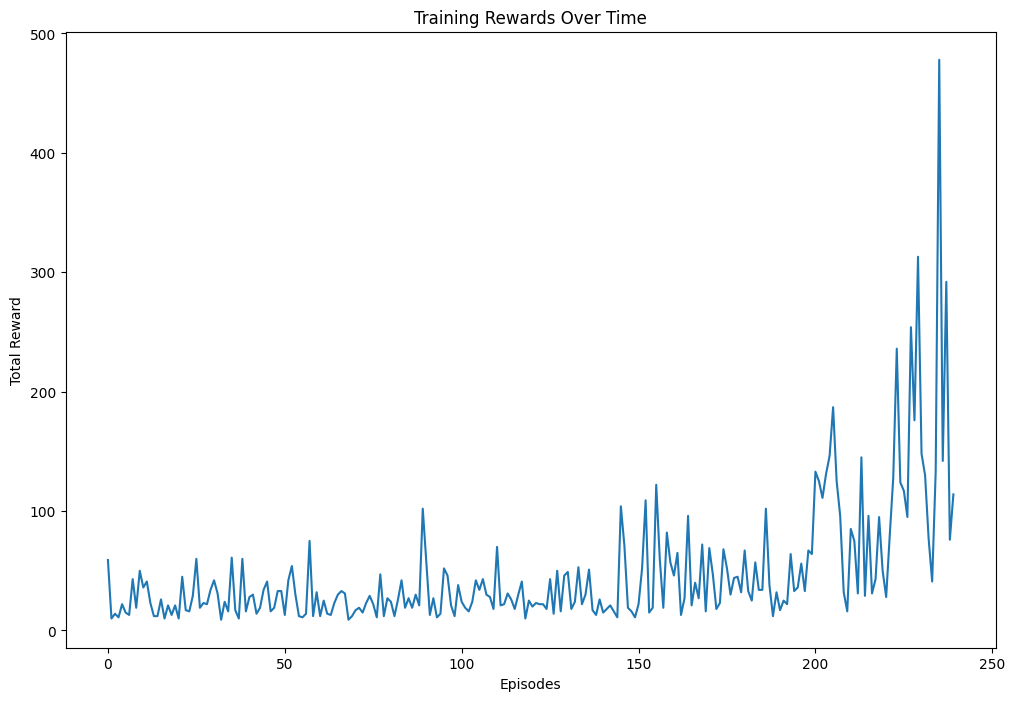

In [9]:
# Train the model
timesteps = 100000
model.learn(total_timesteps=timesteps, callback=callbacks)

# Evaluate the Model

In [10]:
# Evaluate the model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10, render=False)
print(f'Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}')

Mean reward: 402.30 +/- 107.53


Capturing performance after training...
GIF saved at ./after_training.gif


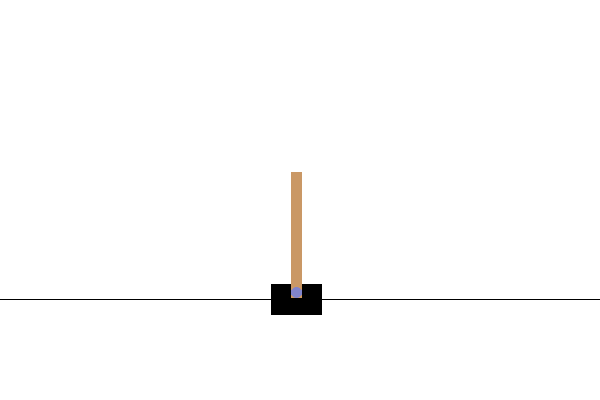

In [11]:
# Capture model performance after training
print("Capturing performance after training...")
run_and_capture_gif(model, env, episodes=1, path="./after_training.gif", duration=500)

# Save the Results

In [12]:
# Save the model
model_name = "ppo_cartpole"
model.save(model_name)

# Save evaluation results
results = {
    "mean_reward": mean_reward,
    "std_reward": std_reward,
    "total_timesteps": timesteps,
    "reward_threshold": reward_threshold
}

with open(f"{model_name}_results.json", "w") as f:
    json.dump(results, f)

print(f"Model saved as {model_name}. Results saved to '{model_name}_results.json'.")

Model saved as ppo_cartpole. Results saved to 'ppo_cartpole_results.json'.


# Hyperparameter Optimization

In [19]:
# Predefine fixed valid values for n_steps and batch_size
n_steps_choices = [128, 256, 512, 1024, 2048]
batch_size_choices = [32, 64, 128, 256, 512]

# Function to optimize PPO using Optuna
def optimize_ppo(trial):
    """Optimization function for PPO using Optuna."""

    # Define the hyperparameter search space
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    n_steps = trial.suggest_categorical('n_steps', n_steps_choices)
    batch_size = trial.suggest_categorical('batch_size', batch_size_choices)
    gamma = trial.suggest_float('gamma', 0.9, 0.9999)
    gae_lambda = trial.suggest_float('gae_lambda', 0.8, 0.99)
    ent_coef = trial.suggest_float('ent_coef', 1e-8, 1e-2, log=True)
    vf_coef = trial.suggest_float('vf_coef', 0.1, 1.0)
    max_grad_norm = trial.suggest_float('max_grad_norm', 0.5, 1.0)
    n_epochs = trial.suggest_int('n_epochs', 1, 10)
    clip_range = trial.suggest_float('clip_range', 0.1, 0.4)

    # Create the PPO model with the trial's hyperparameters
    model = PPO('MlpPolicy', env, verbose=0,
                learning_rate=learning_rate,
                n_steps=n_steps,
                batch_size=batch_size,
                gamma=gamma,
                gae_lambda=gae_lambda,
                ent_coef=ent_coef,
                vf_coef=vf_coef,
                max_grad_norm=max_grad_norm,
                n_epochs=n_epochs,
                clip_range=clip_range)

    # Train the model
    model.learn(total_timesteps=50000)

    # Evaluate the model
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)

    return mean_reward

In [20]:
# Running the optimization with Optuna
study = optuna.create_study(direction='maximize')
study.optimize(optimize_ppo, n_trials=10, n_jobs=1)

# Get and print the best hyperparameters
print("Best hyperparameters found by Optuna:")
print(study.best_params)

[I 2024-08-25 23:42:26,709] A new study created in memory with name: no-name-d7ca1fbe-cb75-453e-a199-34616d13d728
[I 2024-08-25 23:44:23,181] Trial 0 finished with value: 434.6 and parameters: {'learning_rate': 9.490749930207109e-05, 'n_steps': 256, 'batch_size': 32, 'gamma': 0.9599792217167534, 'gae_lambda': 0.8023162236763062, 'ent_coef': 1.0580144307324628e-06, 'vf_coef': 0.34322414355405023, 'max_grad_norm': 0.5394774801014051, 'n_epochs': 6, 'clip_range': 0.1555309293967747}. Best is trial 0 with value: 434.6.
[I 2024-08-25 23:46:04,845] Trial 1 finished with value: 500.0 and parameters: {'learning_rate': 0.0003496339571969611, 'n_steps': 1024, 'batch_size': 64, 'gamma': 0.9849191937080304, 'gae_lambda': 0.8521144654637793, 'ent_coef': 5.149059353654601e-05, 'vf_coef': 0.6888987801491677, 'max_grad_norm': 0.8218718821725958, 'n_epochs': 8, 'clip_range': 0.3293985732563284}. Best is trial 1 with value: 500.0.
[I 2024-08-25 23:47:19,133] Trial 2 finished with value: 371.3 and parame

Best hyperparameters found by Optuna:
{'learning_rate': 0.0003496339571969611, 'n_steps': 1024, 'batch_size': 64, 'gamma': 0.9849191937080304, 'gae_lambda': 0.8521144654637793, 'ent_coef': 5.149059353654601e-05, 'vf_coef': 0.6888987801491677, 'max_grad_norm': 0.8218718821725958, 'n_epochs': 8, 'clip_range': 0.3293985732563284}


# Retrain the Model

In [21]:
# Retrain with the best hyperparameters
best_params = study.best_params
model = PPO('MlpPolicy', env, verbose=1, **best_params)
model.learn(total_timesteps=timesteps)

# Save the optimized model
optimized_model_name = "ppo_cartpole_optimized"
model.save(optimized_model_name)

Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.1     |
|    ep_rew_mean     | 21.1     |
| time/              |          |
|    fps             | 668      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 1024     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 26         |
|    ep_rew_mean          | 26         |
| time/                   |            |
|    fps                  | 580        |
|    iterations           | 2          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2048       |
| train/                  |            |
|    approx_kl            | 0.01942201 |
|    clip_fraction        | 0.0472     |
|    clip_range           | 0.329      |
|    entropy_loss         | -0.681     |
|    explained_variance   | 0.0185     |
|    learning_rate        |

# Final Evaluation

In [22]:
# Evaluate the optimized model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10, render=False)
print(f'Mean reward after optimization: {mean_reward:.2f} +/- {std_reward:.2f}\n')

Mean reward after optimization: 500.00 +/- 0.00



Capturing performance after training...
GIF saved at ./after_training.gif


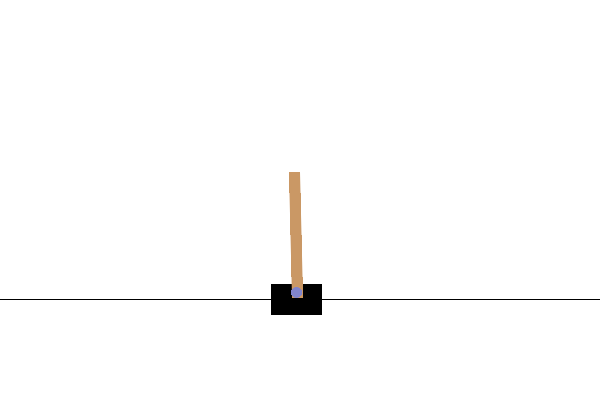

In [23]:
# Capture model performance after training
print("Capturing performance after training...")
run_and_capture_gif(model, env, episodes=1, path="./after_training.gif", duration=500)

# Save Final Results

In [24]:
# Save the final evaluation results
optimized_results = {
    "mean_reward": mean_reward,
    "std_reward": std_reward,
    "best_hyperparameters": best_params,
    "total_timesteps": timesteps,
}

with open(f"{optimized_model_name}_results.json", "w") as f:
    json.dump(optimized_results, f)

print(f"Optimized model saved as {optimized_model_name}. Results saved to '{optimized_model_name}_results.json'.")

Optimized model saved as ppo_cartpole_optimized. Results saved to 'ppo_cartpole_optimized_results.json'.
